# Classificatio with KNN

Dataset preparation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [28]:
df = pd.read_csv('df_cleaned.csv', skipinitialspace=True, header=0)
df['canHaveEpisodes'] = df['canHaveEpisodes'].astype(int)
df.dtypes


originalTitle                   object
rating                         float64
runtimeMinutes                 float64
awardWins                      float64
totalImages                    float64
totalVideos                    float64
totalCredits                   float64
criticReviewsTotal             float64
titleType                       object
awardNominationsExcludeWins    float64
canHaveEpisodes                  int64
numRegions                     float64
userReviewsTotal               float64
countryOfOrigin                 object
genres                          object
decade                           int64
totalReviews                   float64
runtime_category                object
num_ratings                    float64
continent                       object
rating_category                 object
popularity_category             object
dtype: object

C:\Users\rache\AppData\Local\Temp\ipykernel_36196\1731054892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')


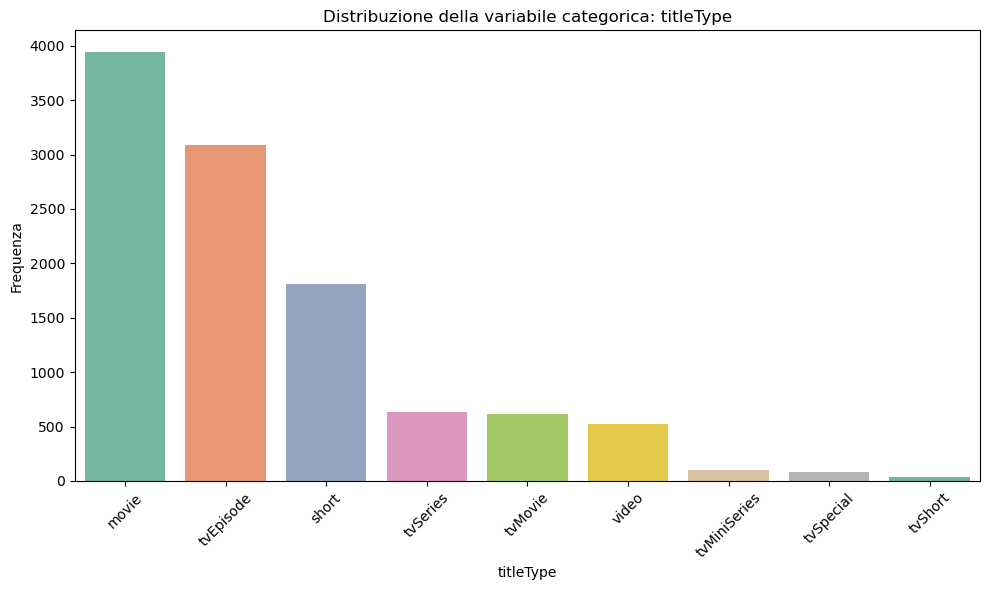

In [8]:


plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')
plt.title('Distribuzione della variabile categorica: titleType')
plt.xlabel('titleType')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\rache\AppData\Local\Temp\ipykernel_36196\2268370951.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')


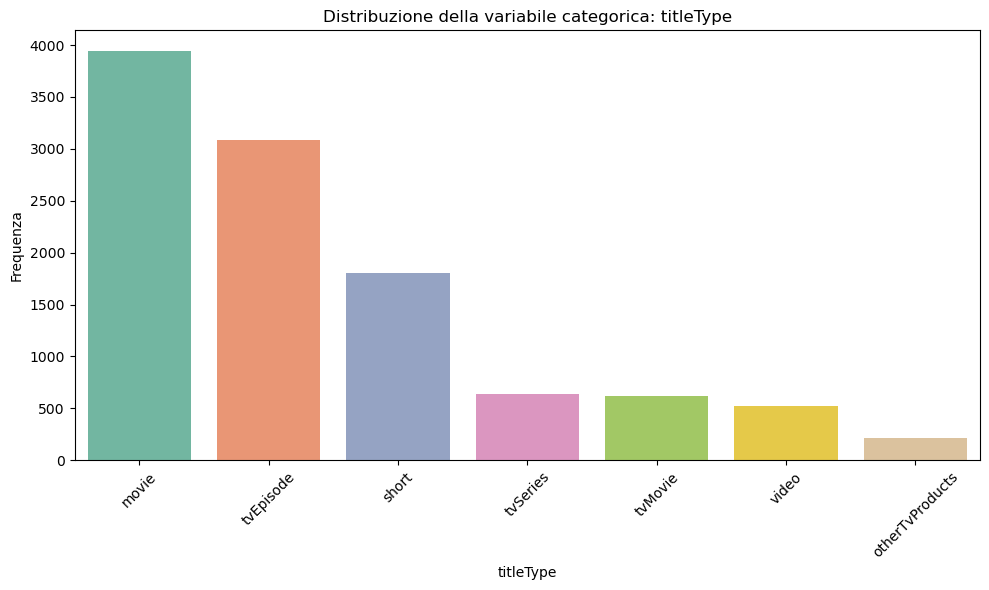

In [29]:
rare_types = ['tvMiniSeries', 'tvSpecial', 'tvShort']
df['titleType'] = df['titleType'].replace(rare_types, 'otherTvProducts')

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='titleType', order=df['titleType'].value_counts().index, palette='Set2')
plt.title('Distribuzione della variabile categorica: titleType')
plt.xlabel('titleType')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
X = df.drop(columns=['rating_category',"originalTitle", "countryOfOrigin", "runtimeMinutes","popularity_category", 'titleType'])
y = df['titleType']
X.columns

Index(['rating', 'awardWins', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'awardNominationsExcludeWins', 'canHaveEpisodes',
       'numRegions', 'userReviewsTotal', 'genres', 'decade', 'totalReviews',
       'runtime_category', 'num_ratings', 'continent'],
      dtype='object')

#Portioning 

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold


In [32]:
# dataset division with stratify

RANDOM_STATE = 0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

K_FOLD = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

print("NaN in X_train['genres']:", X_train['genres'].isna().sum())
print("NaN in X_test['genres']:", X_test['genres'].isna().sum())
print("Controllo tipi in X_train['genres']:")
print(X_train['genres'].apply(type).value_counts())

print("Controllo tipi in X_test['genres']:")
print(X_test['genres'].apply(type).value_counts())




NaN in X_train['genres']: 0
NaN in X_test['genres']: 0
Controllo tipi in X_train['genres']:
genres
<class 'str'>    8663
Name: count, dtype: int64
Controllo tipi in X_test['genres']:
genres
<class 'str'>    2166
Name: count, dtype: int64


# Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

In [34]:
X_train['genres'] = X_train['genres'].fillna('').str.split(',')
X_test['genres'] = X_test['genres'].fillna('').str.split(',')
print("Controllo tipi dopo lo split:")
print(X_train['genres'].apply(type).value_counts())

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# genres: MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_train = mlb.fit_transform(X_train['genres'])
genres_test = mlb.transform(X_test['genres'])

# One-hot encoding su runtime_category e continent
X_cat_train = pd.get_dummies(X_train[['runtime_category', 'continent']], drop_first=True)
X_cat_test = pd.get_dummies(X_test[['runtime_category', 'continent']], drop_first=True)

# Allineamento colonne test rispetto al train
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0)

# Selezione colonne numeriche
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

# Costruzione dei dataset finali in formato DENSE
X_train_enc = np.hstack([
    X_num_train.values,
    genres_train,
    X_cat_train.values
])

X_test_enc = np.hstack([
    X_num_test.values,
    genres_test,
    X_cat_test.values
])

# Verifica consistenza
print("Colonne numeriche:", X_num_train.columns.tolist())
print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc shape:", X_test_enc.shape)
print(type(X_train_enc))

assert X_train_enc.shape[1] == X_test_enc.shape[1], "Numero di colonne tra train e test non corrisponde!"


Controllo tipi dopo lo split:
genres
<class 'list'>    8663
Name: count, dtype: int64
Colonne numeriche: ['rating', 'awardWins', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins', 'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'decade', 'totalReviews', 'num_ratings']
X_train_enc shape: (8663, 49)
X_test_enc shape: (2166, 49)
<class 'numpy.ndarray'>


In [ ]:
# Controllo con DummyClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)

dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train_enc, y_train_enc)
y_pred = dummy.predict(X_test_enc)

print("Accuratezza DummyClassifier:", accuracy_score(y_test_enc, y_pred))

# GridSearch 

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Parametri da esplorare con GridSearchCV
param_grid = {
    "n_neighbors": np.arange(1, min(101, X_train_enc.shape[0] // 5)),  # Numero di vicini
    "weights": ["uniform", "distance"],  # Pesatura dei vicini
    "metric": ["euclidean", "cityblock"],  # Metodi di distanza
}

grid = GridSearchCV(
    KNeighborsClassifier(algorithm='auto'),# Usa ball_tree per velocizzare il calcolo delle distanze
    param_grid=param_grid,  # Parametri da ottimizzare
    cv= K_FOLD,  # K-fold stratificato ripetuto metti la variabile 
    scoring = 'balanced_accuracy',
    n_jobs=-1,  # Usa tutti i core del processore
    refit=True,  # Ritorna il modello migliore
)

# Esegui la ricerca
grid.fit(X_train_enc, y_train_enc) 

# Estrai il modello migliore
clf = grid.best_estimator_

# Mostra i migliori iperparametri e la miglior performance
print("Migliori parametri trovati:", grid.best_params_)
print("Miglior punteggio:", grid.best_score_)


Migliori parametri trovati: {'metric': 'cityblock', 'n_neighbors': np.int64(1), 'weights': 'uniform'}
Miglior punteggio: 0.5224925762169514


In [36]:
# Controllo la distribuzione della variabile target 
print(y_train.value_counts())

titleType
movie              3156
tvEpisode          2471
short              1445
tvSeries            507
tvMovie             493
video               417
otherTvProducts     174
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import label_binarize

# Predizioni sui dati di test
y_test_pred = clf.predict(X_test_enc)

In [38]:
print("Accuracy:", accuracy_score(y_test_enc, y_test_pred))

Accuracy: 0.7419205909510619


In [39]:
print("F1 Macro:", f1_score(y_test_enc, y_test_pred, average="macro"))

F1 Macro: 0.5665797398818537


In [40]:
print("F1 Macro:", f1_score(y_test_enc, y_test_pred, average="micro"))

F1 Macro: 0.7419205909510619


In [41]:
print("\nClassification Report:\n", classification_report(y_test_enc, y_test_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       789
           1       0.21      0.23      0.22        43
           2       0.87      0.87      0.87       361
           3       0.79      0.84      0.81       618
           4       0.20      0.22      0.21       124
           5       0.77      0.44      0.56       127
           6       0.49      0.50      0.49       104

    accuracy                           0.74      2166
   macro avg       0.59      0.56      0.57      2166
weighted avg       0.75      0.74      0.74      2166



# ***CONFUSION MATRIX***

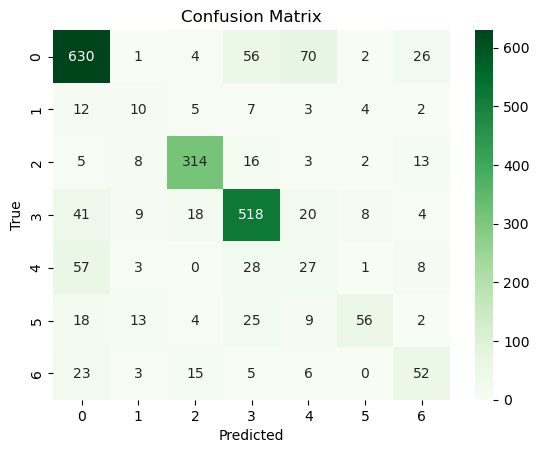

In [42]:
cf = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve Multiclasse ---

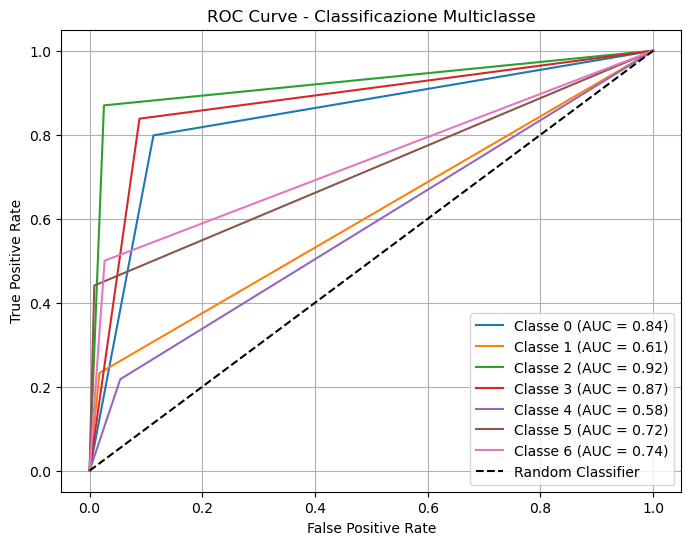

ROC AUC macro: 0.7545460593549863


In [43]:

# Otteniamo le probabilità
y_test_pred_proba = clf.predict_proba(X_test_enc)

# Binarizziamo le etichette (necessario per ROC multiclasse)
n_classes = y_test_pred_proba.shape[1]
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(n_classes))

# Calcolo curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classificazione Multiclasse")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC complessiva
print("ROC AUC macro:", roc_auc_score(y_test_binarized, y_test_pred_proba, average="macro", multi_class="ovr"))

# NAIVE BEYES CATEGORICO

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_enc, y_train_enc)

# Previsioni
y_pred_mnb = clf_mnb.predict(X_test_enc)

# Valutazione
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred_mnb)}")
print(classification_report(y_test_enc, y_pred_mnb))

Accuracy: 0.7663896583564174
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       789
           1       0.33      0.02      0.04        43
           2       0.86      0.89      0.87       361
           3       0.81      0.73      0.77       618
           4       0.10      0.02      0.03       124
           5       0.89      0.98      0.93       127
           6       0.76      0.31      0.44       104

    accuracy                           0.77      2166
   macro avg       0.64      0.55      0.56      2166
weighted avg       0.73      0.77      0.73      2166



In [46]:
clf_mnb.predict_proba(X_test_enc)

array([[5.44115601e-01, 1.14085242e-02, 7.72100814e-02, ...,
        1.15073240e-01, 1.64979648e-02, 1.70121567e-02],
       [8.92387803e-01, 3.08944865e-03, 1.85423111e-04, ...,
        6.35773375e-02, 3.71406460e-03, 6.93950361e-03],
       [5.96671642e-06, 2.40363791e-02, 1.20139688e-02, ...,
        2.62106357e-03, 1.00388691e-01, 4.16061969e-03],
       ...,
       [7.38787804e-01, 1.00255755e-02, 5.63792578e-02, ...,
        1.52460477e-01, 2.98042600e-02, 3.27786339e-03],
       [3.76752978e-01, 8.79692026e-03, 6.21833309e-04, ...,
        3.69188104e-02, 9.35499593e-03, 1.70098985e-02],
       [8.91975521e-01, 3.66834643e-03, 3.87523229e-02, ...,
        4.30207155e-02, 1.81627081e-02, 2.49904672e-03]], shape=(2166, 7))

# ---ROC CURVE---

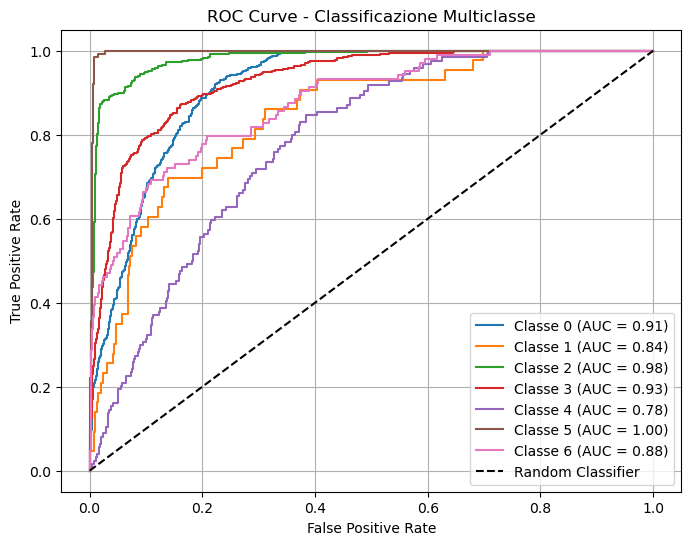

ROC AUC macro: 0.9027396909334033


In [47]:
# Otteniamo le probabilità
y_test_pred_proba = clf_mnb.predict_proba(X_test_enc)

# Binarizziamo le etichette (necessario per ROC multiclasse)
n_classes = y_test_pred_proba.shape[1]
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(n_classes))

# Calcolo curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classificazione Multiclasse")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC complessiva
print("ROC AUC macro:", roc_auc_score(y_test_binarized, y_test_pred_proba, average="macro", multi_class="ovr"))